### This script performs several tasks involving generation of depth maps, and 3D point clouds. The key steps of the script can be summarized as follows:

1. Input Data: The script takes RGB images, head mesh models, and camera parameters as input.

2. Depth Map Generation: The script uses the RGB images and camera parameters to generate depth maps.

3. 3D Head Point Cloud Creation: Using the generated depth maps and the corresponding RGB images, the script creates a 3D head point cloud. 

4. Point Cloud Downsampling: To manage the size of the point cloud, the script downsamples the point cloud. Downsampling reduces the number of points in the cloud while preserving essential structural details.

5. Point Cloud Alignment: The script aligns the downsampled point cloud to a specific coordinate system. This ensures that all point clouds are in the same 3D world coordinate space, facilitating comparisons and combining scans from different identities.

6. Point Cloud Rendering: The final step involves rendering the aligned, downsampled point cloud. Rendering provides a visual representation of the 3D head point cloud, enabling visualization and analysis of the captured 3D data.

Please note that: The dataset structure follows the format of the original FaceScape dataset.
This means that the data organization, file naming conventions, and directory structure
are designed to be compatible with the FaceScape dataset for consistency and ease of use.
Users should refer to the FaceScape documentation for further details
on the dataset's specific attributes and their meanings.
Link to FaceScape documentation: <https://github.com/zhuhao-nju/facescape>

In [24]:
# render multi-view model
import cv2, json, os
import numpy as np
import src.renderer as renderer
from PIL import Image
import json
import trimesh
import pyrender
import src.render_point_cloud as renderer2
import src.utility as util
os.environ['PYOPENGL_PLATFORM'] = 'egl'

### Specify the Id and Expression of the individual you want to render.

In [25]:
id, id_idx = str(212), 212 # identity index of this sample is 212
expression = "1_neutral"
exp_idx = 1 # expression index of this sample is neutral
#RGB frames to be used for reconstruction (we do not need all frames)
cam_idx_list = [0, 5, 15, 21, 27, 30, 35, 38, 45, 57] 

#path to multiview images folder
path_to_img_folder = os.path.join("./fsmview_trainset_images_201-220/fsmview_trainset/",\
                                  str(id), expression )
#path to 3D head mesh model file
path_to_mesh_folder = os.path.join("./fsmview_trainset_shape_201-220/fsmview_trainset/",\
                                   str(id), expression+".ply")

### Generate depth maps for each RGB image and render them together

In [26]:
# Read camera parameters
with open(os.path.join(path_to_img_folder,"params.json" ), 'r') as f:
    params = json.load(f)

rgb_image_paths = [os.path.join(path_to_img_folder, x) for x in \
    sorted(os.listdir(path_to_img_folder)) if x.endswith(('jpg', 'png'))]

for img_path in rgb_image_paths:
    img_id = path_to_img_folder.split('/')[-2]+'_'+path_to_img_folder.split('/')[-1] 
    cam_idx = int(img_path.split('/')[-1].split('.')[0] )  #extract camera index 

    # extract KRt
    K = np.array(params['%d_K' % cam_idx])
    Rt = np.array(params['%d_Rt' % cam_idx])
    h_src = params['%d_height' % cam_idx]
    w_src = params['%d_width' % cam_idx]

    # scale K RT h w
    scale = 0.2
    h, w = int(h_src * scale), int(w_src * scale)
    K[:2,:] = K[:2,:] * scale

    # render depth data
    rend_depth, rend_img = renderer.render_cvcam(path_to_mesh_folder, K, Rt, rend_size=(h, w))
    dir_name = "./depth_output/%s/" %img_id
    os.makedirs(dir_name, exist_ok = True)
    np.save(os.path.join(dir_name ,"mview_depth_view_%d.npy") % cam_idx, rend_depth)     

### Create the point cloud by combining depth information with corresponding RGB images.

In [30]:
def write_ply_file(filename, list_name):
    file = open(filename, "w")
    file.write('''ply
    format ascii 1.0
    element vertex %d
    property float x
    property float y
    property float z
    property uchar red
    property uchar green
    property uchar blue
    property uchar alpha
    end_header
    %s
    ''' % (len(list_name), "".join(list_name)))
    file.close()
    print("Write into .ply file Done.")


def write_pointcloud(filename,xyz_points,rgb_points=None):
    """ creates a .pkl file of the point clouds generated
    """
    assert xyz_points.shape[1] == 3,'Input XYZ points should be Nx3 float array'
    if rgb_points is None:
        rgb_points = np.ones(xyz_points.shape).astype(np.uint8)*255
    assert xyz_points.shape == rgb_points.shape,'Input RGB colors should be Nx3 float array \
    and have same size as input XYZ points'
    
    #put nformation to the map to reduce number of points in the same location to single value 
    point_cloud_map = {}
    for k in range(len(xyz_points)):
        point_cloud_map[tuple(xyz_points[k])] = rgb_points[k]
    
    float_formatter = lambda x: "%.4f" % x
    points =[]
    for i in range (len(xyz_points)):
        points.append("{} {} {} {} {} {} 0\n".format
        (float_formatter(xyz_points[i][0]), 
        float_formatter(xyz_points[i][1]),
        float_formatter(xyz_points[i][2]),
        int(rgb_points[i][0]),
        int(rgb_points[i][1]), 
        int(rgb_points[i][2])))
    return points

def get_pointcloud(color_image,depth_image,camera_intrinsics):
    """ creates 3D point cloud of rgb images by taking depth information
        input : color image: numpy array[h,w,c], dtype= uint8
                depth image: numpy array[h,w] values of all channels will be same
        output : camera_points, color_points - both of shape(no. of pixels, 3)
    """
    image_height = depth_image.shape[0]
    image_width = depth_image.shape[1]
    pixel_x,pixel_y = np.meshgrid(np.linspace(0,image_width-1,image_width),
                                  np.linspace(0,image_height-1,image_height))
    camera_points_x = np.multiply(pixel_x-camera_intrinsics[0,2],depth_image/camera_intrinsics[0,0])
    camera_points_y = np.multiply(pixel_y-camera_intrinsics[1,2],depth_image/camera_intrinsics[1,1])
    camera_points_z = depth_image
    camera_points = np.array([camera_points_x,camera_points_y,camera_points_z]).transpose(1,2,0).reshape(-1,3)
    color_image = np.array(color_image)
    color_points = color_image.reshape(-1,3)
    # Remove invalid 3D points (where depth == 0)
    valid_depth_ind = np.where(depth_image.flatten() > 0)[0]
    camera_points = camera_points[valid_depth_ind,:]
    color_points = color_points[valid_depth_ind,:]
    return camera_points,color_points


depth_path = os.path.join("./depth_output", id+"_"+expression)
depth_paths = [depth_path+'/'+x for x in sorted(os.listdir(depth_path)) if x.endswith(('npy'))]

point_clouds = []
i = 0
for img_path in rgb_image_paths:
    cam_idx = int(img_path.split('/')[-1].split('.')[0].split('_')[0] )  #extract image name
    if cam_idx not in cam_idx_list:
        K = np.array(params['%d_K' % cam_idx])
        Rt = np.array(params['%d_Rt' % cam_idx])
        h_src = params['%d_height' % cam_idx]
        w_src = params['%d_width' % cam_idx]
        scale = 0.2
        h, w = int(h_src * scale), int(w_src * scale)
        K[:2,:] = K[:2,:] * scale
        camera_intrinsics = np.asanyarray(K)
        rgb_img = Image.open(img_path)
        color_data = rgb_img.resize((w, h))
        depth_data = np.load(depth_paths[i]) #depth info

        dir_name = "./point_cloud/" #where to save pointclouds
        os.makedirs(dir_name, exist_ok = True)

        output_filename = os.path.join("./point_cloud", img_id+'-pointCloud.ply') #where to save pointcloud
        camera_points, color_points = get_pointcloud(color_data, depth_data, camera_intrinsics)
        rotation, translation  = Rt[:,0:3], Rt[:,3]
        inverse_translation=-1 * translation
        inverse_rotation= rotation.transpose()
        
        camera_points = np.matmul((camera_points - translation) , rotation)
        points = write_pointcloud(output_filename, camera_points, color_points)
        point_clouds.extend(points)
    i = i+1
print("Creating the point Cloud file at : ", output_filename)
write_ply_file(output_filename, point_clouds)
    

Creating the point Cloud file at :  ./point_cloud/212_1_neutral-pointCloud.ply
Write into .ply file Done.


### Down-sample the pointcloud

In [28]:
import point_cloud_utils as pcu
import numpy as np

# v is a nv by 3 NumPy array of vertices
# n is a nv by 3 NumPy array of vertex normals
# c is a nv by 4 NumPy array of vertex colors
path = os.path.join("./point_cloud",str(id)+'_'+expression+"-pointCloud.ply")
v, n, c = pcu.load_mesh_vnc(path)

# We'll use a voxel grid with 1400 voxels per axis
num_voxels_per_axis = 1400

# Size of the axis aligned bounding box of the point cloud
bbox_size = v.max(0) - v.min(0)

# The size per-axis of a single voxel
sizeof_voxel = bbox_size / num_voxels_per_axis

# Downsample a point cloud on a voxel grid so there is at most one point per voxel.
# Multiple points, normals, and colors within a voxel cell are averaged together.
v_sampled, n_sampled, c_sampled = pcu.downsample_point_cloud_voxel_grid(sizeof_voxel, v, n, c)

pcu.save_mesh_vnc(os.path.join("./point_cloud", str(id)+"_"+expression+"_downSampled.ply"),\
                  v_sampled, n_sampled, c_sampled)

### Align all the point clouds to a common 3D world coordinate system.

aligned mview_model saved to :  ./demo_output/212_1_neutral_canonical.ply


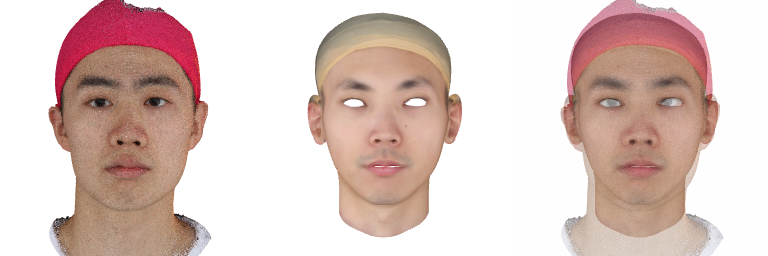

In [29]:

model_in = os.path.join("./point_cloud",str(id)+'_'+expression+"_downSampled.ply")
mview_mesh = trimesh.load(model_in, process=False)

# seperate point coordinates from color and create mesh
pr_mesh = pyrender.Mesh.from_points(mview_mesh.vertices, mview_mesh.colors)
# read Rt scale
with open("./Rt_scale_dict.json", 'r') as f:
    Rt_scale_dict = json.load(f)
    scale = Rt_scale_dict['%d'%id_idx]['%d'%exp_idx][0]
    Rt = np.array(Rt_scale_dict['%d'%id_idx]['%d'%exp_idx][1])

# align multi-view model to TU model
mview_mesh.vertices *= scale
mview_mesh.vertices = (np.tensordot(Rt[:3,:3], mview_mesh.vertices.T, 1).T + Rt[:3, 3])

os.makedirs("./demo_output/", exist_ok=True)
path_to_save = os.path.join("./demo_output", str(id)+'_'+expression+"_"+"canonical.ply")
mview_mesh.export(path_to_save)
print("aligned mview_model saved to : ", path_to_save)

#render point cloud with your desired camera
# set camera parameters
K = np.array([[1000, 0, 128],
              [0, 1000, 128],
              [0, 0, 1]], dtype=np.float64)

Rt = np.array([[1, 0, 0, 0],
               [0, -1, 0, 0],
               [0, 0, -1, 1200]], dtype=np.float64)

h, w = 256, 256
K = K
Rt = Rt
mview_mesh = path_to_save
_, rend_mview_model = renderer2.render_cvcam(mview_mesh, K, Rt, rend_size=(h, w), flat_shading=True)
tu_base_mesh = trimesh.load("./sample_tu_model/1_neutral.obj", process=False)
tu_base_mesh.visual.material.diffuse = np.array([255, 255, 255, 255], dtype=np.uint8)
_, rend_tu_model = renderer.render_cvcam(tu_base_mesh, K, Rt, rend_size=(h, w), 
                                         flat_shading=True)

merge_img = (rend_mview_model//2) + (rend_tu_model//2)
vis_img = np.concatenate((rend_mview_model, rend_tu_model, merge_img), 1)
util.show_img_arr(vis_img, bgr_mode = True)